In [1]:
# More MLP!

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('./data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [115]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / ((n_embd * block_size)**0.5)) # ~.3
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Instead of 0 for just a little bit of entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# For batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmeani = torch.zeros((1, n_hidden))
bnstdi = torch.ones((1, n_hidden)) 
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [116]:
(5/3) / (30**.5)

0.3042903097250923

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  # We can instead also do a running mean and std, so we don't have to a do a separate step after
  # to tune the mean and std for inference
  # We're not using gradient descent, so we do no_grad
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # Break used to inspect initial values
  # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [39]:
embcat.shape, W1.shape, b1.shape

(torch.Size([32, 30]), torch.Size([30, 200]), torch.Size([200]))

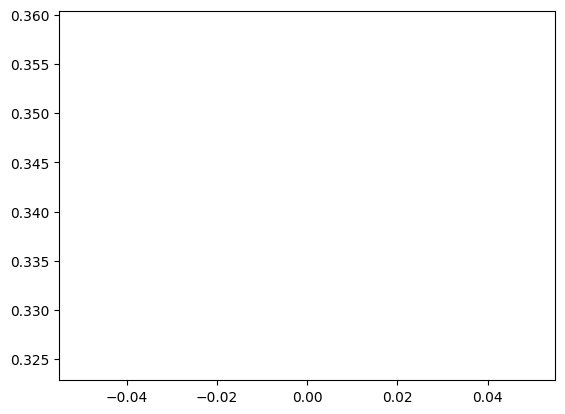

In [40]:
plt.plot(lossi)

In [107]:
# calibrate batch norm at end of training

with torch.no_grad():
  # pass training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure over entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

  # We use the calculated mean and std so we can do runs on individual entries
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


In [106]:
# Losses - 

# Original
# train 2.12
# val 2.16

# After scaling W2 and b2 to be small (to make the output distrubiton more uniform initially)

# train 2.069589138031006
# val 2.1310746669769287

# After scaling W1 and b1 to be small (to stop the tanh from being saturated initially)

# train 2.035708427429199
# val 2.1029489040374756

# After adding a batch norm layer
# train 2.06
# val 2.10
# P much the same as previous, but batch norm shows it's power when you have larger networks with more stuff going on

In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, n_embd)
    refactored_emb = emb.view(1, -1)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and trakc the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndyn.
alerethruthadrie.
cadelyn.
elin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshimies.
kin.
renlynn.
novana.
ubeen.
der.


In [14]:
# First thing we want to look at is the initialization - 
# At the zero'th iteration, the loss is 26.5404! Because the Weights are completely random!
# We can have a much lower loss at initialization
# Since we have only 27 possible next characters, a completely uniform distribution would give us the odds of 
# 1/27 = .037 for each character
# The loss, or - logprob =
loss = -torch.log(torch.tensor(1/27)).item()
print(loss)
# Is actually 3.2958 - much lower

3.295836925506592


In [15]:
# 4-dimensional example of the issue
# Loss is minimized here with no training
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
# Loss is really bad here in this random initialization
# logits = torch.tensor([10.0, 0.0, 0.0, 0.0])
# Loss is really low here in this random intialization
# logits = torch.tensor([0.0, 0.0, 10.0, 0.0])

# The higher the c, the higher loss is!
# Conversely, the smaller c, the lower the loss is! (When starting with random initial values)
c = 10
logits = torch.randn(4) * c

probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

# So ultimately, what we can do is sacale W2 by a small number (0.01)
# And 0 the b2
# Now the initial loss is very close to what we would expect (3.29), but we still maintain a bit of entropy

# Once we do this, the plot of the loss loses it's hockeystick appearance
# This also reduces our overall loss too! This is because we spend more time actually optimizing the neural net 
# Instead of flattening out the randomness!

# However, one thing we have to keep an eye out is for h - notice that a lot of the values in h now are -1 or 1!

# Why not just set it straight to zero?
# In our case, this is probably fine, but there are reasons not to - we'll get to this later

(tensor([1.9722e-11, 1.4363e-01, 7.1198e-11, 8.5637e-01]), tensor(23.3656))

(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

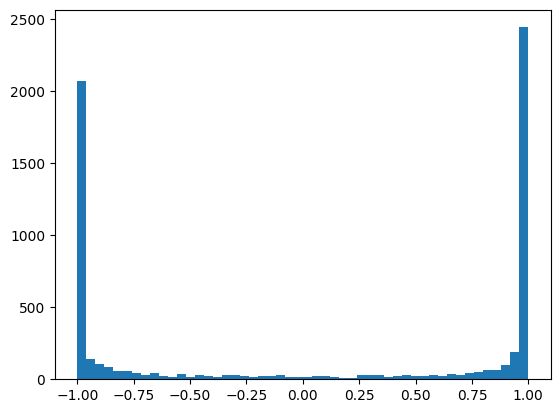

In [48]:
# Another thing we have to keep an eye out is for h - notice that a lot of the values in h now are -1 or 1!
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

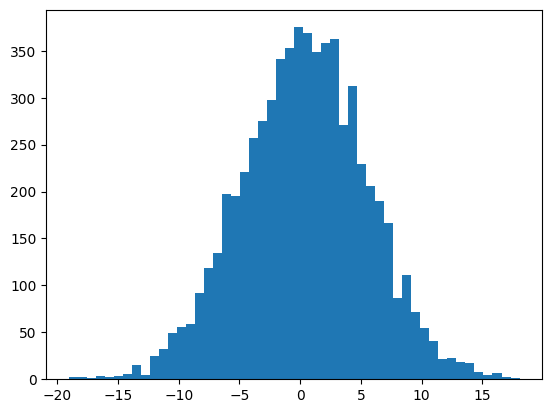

In [ ]:
# This is because the pre-activations of the tanh are very broad! (from -20 to 20!), and this gets squashed to -1 and 1
plt.hist(hpreact.view(-1).tolist(), bins=50)

In [25]:
# This is really bad because of how tanh backpropogates it's gradient!
# The backpropgation of tanh's gradient is (+= (1 - tanh^2))
# So if tanh is 1 or -1, this ends up being 0, and gradient backpropogation essentially stops!

# Tanh being 1 or -1 also implies x being inf or -inf - (which is what occurs due to float rounding)
# So it is not longer possible to meaningfully bockpropogate

# Tanh being 0 also implies the derivative is 1 - this means any gradient passes through completely!
# The more you are in the flat tails (closer to inf or -inf), the more the gradient is squashed!
# f(g(x))' = f'(g(x)) g'(x)

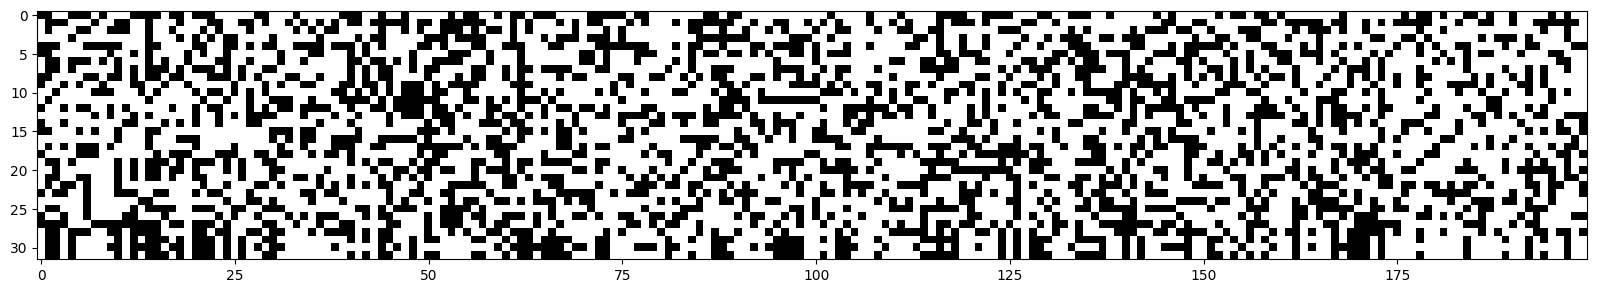

In [50]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation='nearest')
# White is true, black is false

# A full column being white indicates a dead neuron!
# That means that for every input example, the tanh gradient is 0, meaning that no lerning can occur!

# However, no column is fully white here, and so every neuron will learn for at least one example in the data!
# As a result, no neuron is fully "dead"

In [ ]:
# ReLu suffers from a similar issue! All of the activation functions do.
# Relu is f(x) = x if x >= 0, 0 if x < 0
# You could have a dead neural network if the initial initialization makes it so that for all the input training examples, x < 0, as the slope is 0, and ReLU will never learn!

# A dead neuron can happen during optimization as well - if the learning rate is too high, the gradient can knock the value of the parameters of the neuron off so that no example in
# the training dataset will activate it, and thus making the neuron dead

# ELU and Leaky ReLU attempt to fix this issue by getting rid of the flat tail for ReLU (the 0 if x < 0)

torch.Size([1, 200])

(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

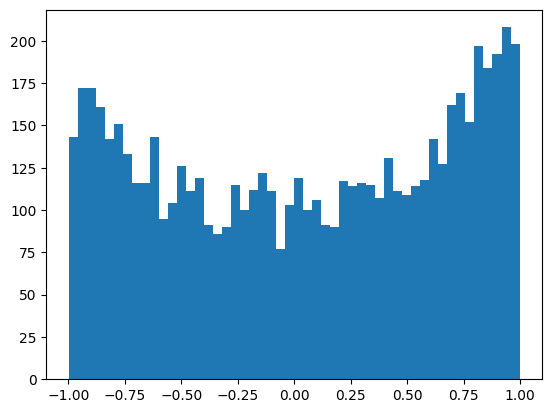

In [59]:
# The issue with our current data, is that h preact is already really spread out - if we can scale h preact to be closer to 0, then we won't have the issue of having dead / close to dead nuerons
# And this should hopefully give us better loss long term!
# We also scale b to .1 - we could set it to 0, but the .1 gives a little bit of entropy

# Notice how h looks now - it's just from -1 to 1
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367092, -3.62009715, -3.47652338, -3.33294961, -3.18937584,
        -3.04580207, -2.9022283 , -2.75865453, -2.61508076, -2.47150699,
        -2.32793322, -2.18435945, -2.04078568, -1.8972119 , -1.75363813,
        -1.61006436, -1.46649059, -1.32291682, -1.17934305, -1.03576928,
        -0.89219551, -0.74862174, -0.60504797, -0.4614742 , -0.31790043,
        -0.17432666, -0.03075289,  0.11282088,  0.25639465,  0.39996842,
         0.54354219,  0.68711596,  0.83068974,  0.97426351,  1.11783728,
         1.26141105,  1.40498482,  1.54855859,  1.69213236,  1.83570613,
         1.9792799 ,  2.12285367,  2.26642744,  2.41000121,  2.55357498,
 

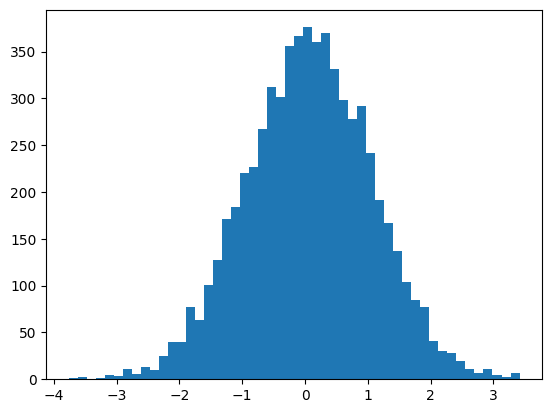

In [60]:
# And the hpreact is also much closer to 0 
plt.hist(hpreact.view(-1).tolist(), bins=50)

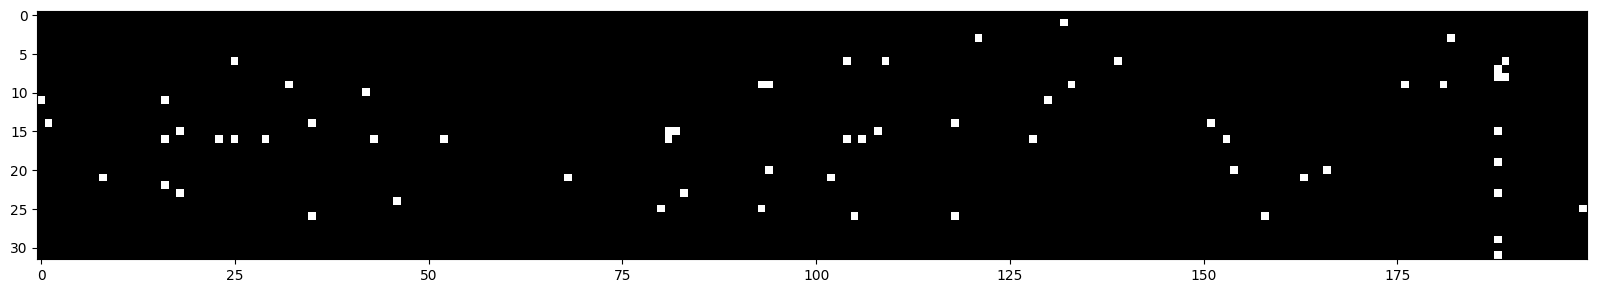

In [ ]:
# And our neurons are much more willing to learn!
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation='nearest')

In [66]:
# Right now, these initializations might not seem like such a big deal, but when networks get bigger and bigger, (i.e 50 layers) these problems stack up, and
# you can have issues with networks not even learning!

In [70]:
# How do you choose the scale for the initial values! 
# We don't just randomly choose them - there is some principled ways of doing so.

tensor(0.0030) tensor(0.9970)
tensor(0.0004) tensor(0.9962)
tensor(0.0025) tensor(0.7534)


(array([2.90975069, 1.15175027, 0.86887521, 0.68925016, 0.58175014,
        0.50175012, 0.46762511, 0.4050001 , 0.38737509, 0.34825008,
        0.32950008, 0.33337508, 0.31475008, 0.29687507, 0.28375007,
        0.27887507, 0.27575007, 0.27175006, 0.25900006, 0.26012506,
        0.25400006, 0.25487506, 0.24475006, 0.25350006, 0.25225006,
        0.24100006, 0.25312506, 0.24650006, 0.26500006, 0.25537506,
        0.24875006, 0.26162506, 0.26850006, 0.27575007, 0.28212507,
        0.28512507, 0.29625007, 0.30650007, 0.32387508, 0.33287508,
        0.34912508, 0.38462509, 0.4153751 , 0.46037511, 0.50762512,
        0.57575014, 0.70025017, 0.8547502 , 1.18137528, 2.9538757 ]),
 array([-1.00000000e+00, -9.60000010e-01, -9.20000019e-01, -8.80000029e-01,
        -8.40000038e-01, -8.00000048e-01, -7.60000057e-01, -7.20000067e-01,
        -6.80000076e-01, -6.40000086e-01, -6.00000095e-01, -5.60000105e-01,
        -5.20000114e-01, -4.80000124e-01, -4.40000134e-01, -4.00000143e-01,
        -3.600

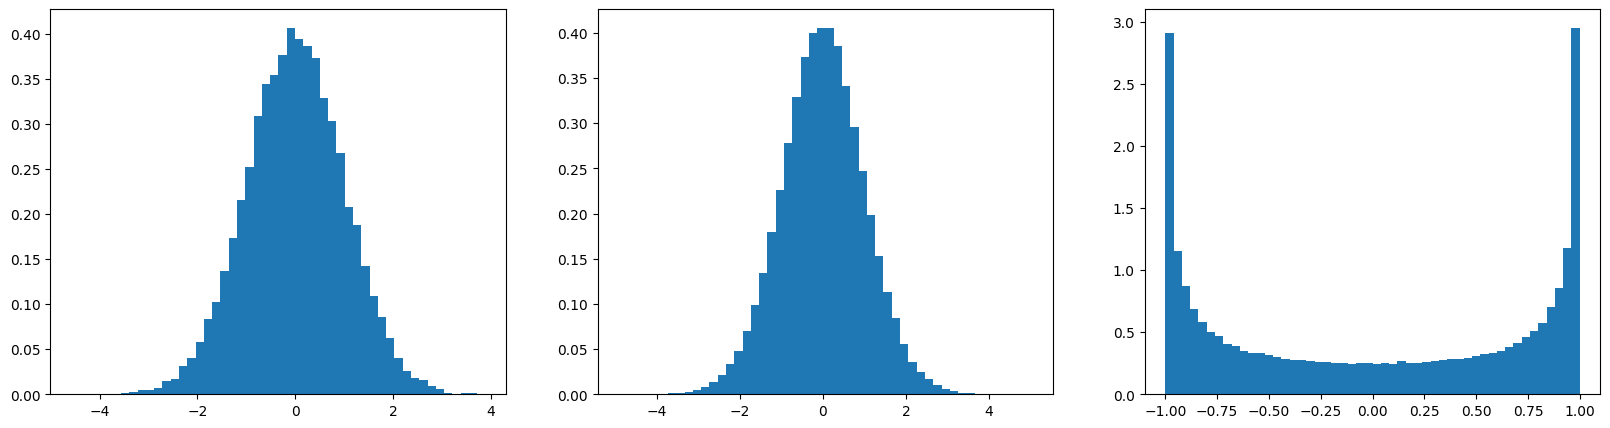

In [83]:
x = torch.randn(1000, 30)
w = torch.randn(30, 200) / 30 ** 0.5
ypreact = x @ w

w = torch.randn(30, 200)  / (30 ** 0.5) * 5/3
y = torch.tanh(x @ w)

print(x.mean(), x.std())
print(ypreact.mean(), ypreact.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50, density=True)

plt.subplot(132)
plt.hist(ypreact.view(-1).tolist(), 50, density=True)

plt.subplot(133)
plt.hist(y.view(-1).tolist(), 50, density=True)

# The standard deviation of y is much higher than x (x is 1, as expected for gaussian, and y is 5.4)
# We need to scale w so that the std of y is closer to 1 - this is the scaling factor we want to use for initialization!
# To do this, you need to divide w by the sqt of the fan in - or the number of input elements (30 here)

In [ ]:
# For optimal initaliztion, the activation function matters a lot too!
# For ReLu, since you throw away have of the inputs, you want to scale by sqrt(2/fanout) (multiply by sqt(2) / sqt(fanout)) - sqt(2) is called the "gain"
# Each function has it's own different scale!

# The paper finds that maintaing the std in the activations and gradients has the same effect on training ultimately

# You can use torch.nn.kaiming_normal_ to initialize with this setup

# For tanh - the "gain" is 5/3
# This is needed, because tanh is a "contractive" operation (it squeezes the ends hard) - so the gain is needed to balance the squeeze out for the std
# You may ask - why not just make the values really small?
# While the slope will be maximal closer to 0, this is bad, because all the outputs will be 0, and deeper layers will be barely able to learn as they would get almost no signal

In [93]:
# However, this initialization isn't as important nowadays because of batch normalization
# What is batch normalization?
# Well we want the hidden states to be gaussian - so why don't we just normalize them during training?
# These are all differentiable operations too - so it won't negatively affect backprop!

In [ ]:
# We do this by minusing the mean from hpreact, and then dividing by the variance! This is what batch normalization is
# hpreact shape is input sample x neuron activation
hpreact.shape
hpreact.mean(0, keepdim=True).shape
normalized_hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) 

# However, we only want this for initialization - as the model gets trained - we want to add some flexibility to this 
# so that it doesn't exactly have to be a unit gaussian and so that it can move around (with a bias)
# so we do 
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
normalized_hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

In [100]:
hpreact.mean(0, keepdim=True).shape, hpreact.shape

(torch.Size([1, 200]), torch.Size([32, 200]))

In [ ]:
# Overall, batch normalization stabalizes large neural network training drastically!
# It's great!
# However, there's some issues now with batch normalization - 
# Hidden state activations are all of a sudden dependent on all the other training examples in the dataset!
# However, this ends up actually being beneficial! This extra jitter regularizes the neural network (prevents overfitting)

# No one likes the property that hpreact activation of other examples in the batch affect each other - but it just works too well!

# But with batch normalization - how do we forward just a single example? (As now it expects batches of data)
# After training is done - you take the mean and variance with respect to the whole training dataset and use that!

# However, people don't like having a separate step after tuning, so instead we can get a running mean and std!
# The values are not identical to the full mean and std over the training dataset - but it is very close!

# Also - notice that b1 is now useless! This is because we average b across the batch and subtract it from hpreact - so it just goes away
# So we can comment that out!
# The bias is encoded in bnbias instead!
# (The batch normalization adds the bias)

In [ ]:
# The typical motif you see in neural networks is 
# Weight layer
# Normalization layer
# Non-linearity layer

# Sometimes with a residual layer
# This motif is repeated constantly in deep neural networks!

In [ ]:
# With pytorch, we would use their prebuilt packages - i.e torch.nn.Linear
# There are some differences (they use uniform distribution instead of gaussian for initializing weights), but pretty much same idea!

# Similarly for batchnorm
# They have a momentum parameter - that's what's used to calculate the running mean and variance
# We have a small batch size, so we use a small momentum, as there's much more variance
# If the momentum is too large, the running mean and variance might thrash too much

# In reality - there are a lot of alternatives to batch normalization!
# i.e group normalization, layer normalization

In [119]:
# SUMMARY + PYTORCHIFYING -----------

In [190]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident (to simulate a uniform distribution)
  layers[-1].weight *= 0.1
  # all other layers: apply gain (5/3 is the tanh gain!)
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [195]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2944


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

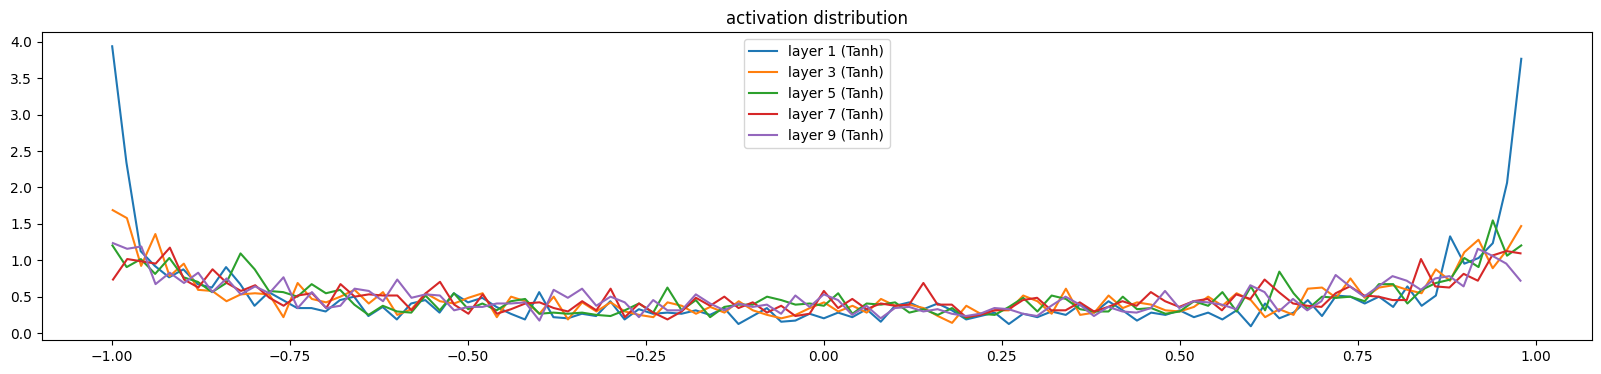

In [180]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

# If we use 1 - the std deviation becomes too small, and the activations start to vanish over time as well
# This will slow down the learning rate!
# If we use 2 (or a higher number) - the saturation gets way to high!
# Not really sure why 5/3 to be honest - just works really well empirically (take that reasoning for now)
# Visually you get a pretty good distribution of the values - where the activations are similiar values across layers, and there's not too much saturation!

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

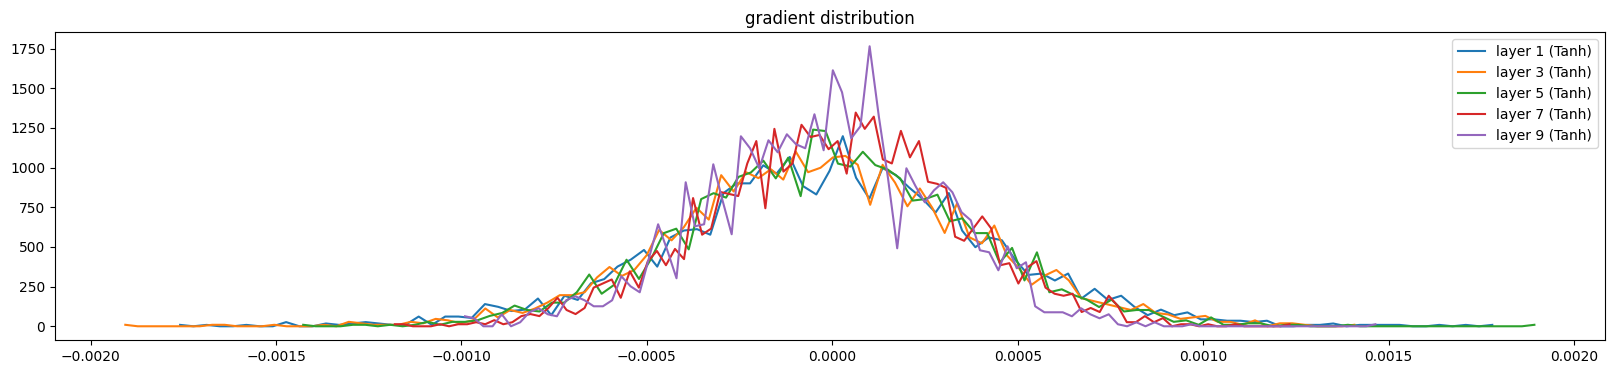

In [186]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

# Visiually - we want the gradient distribution for each layer to be roughly the same - 
# (We don't want any individual layer to be growing faster or slower)
# This occurs best when the gain is 5/3 as well!

In [182]:
# If we only use linear layers - the gradients dissapear, and the activations get really spread out.
# This is horrible in very deep neural networks
# There's not much learning going on and you have really spread out values
# Similarly, the opposite occurs when the gain is too small
# If the gain is 1 (which is what is expected for a linear neural networK) The distributions are as expected

In [183]:
# Before we had these initialization techniques - Deep learning was effectively impossible, since it was really hard to figure out the right initialization values!

In [184]:
# Why do we need non-linearity? If we don't have that, it's really just one linear layer!
# But due to the chain rule, the back propogation dynamics are very different 

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


Text(0.5, 1.0, 'weights gradient distribution')

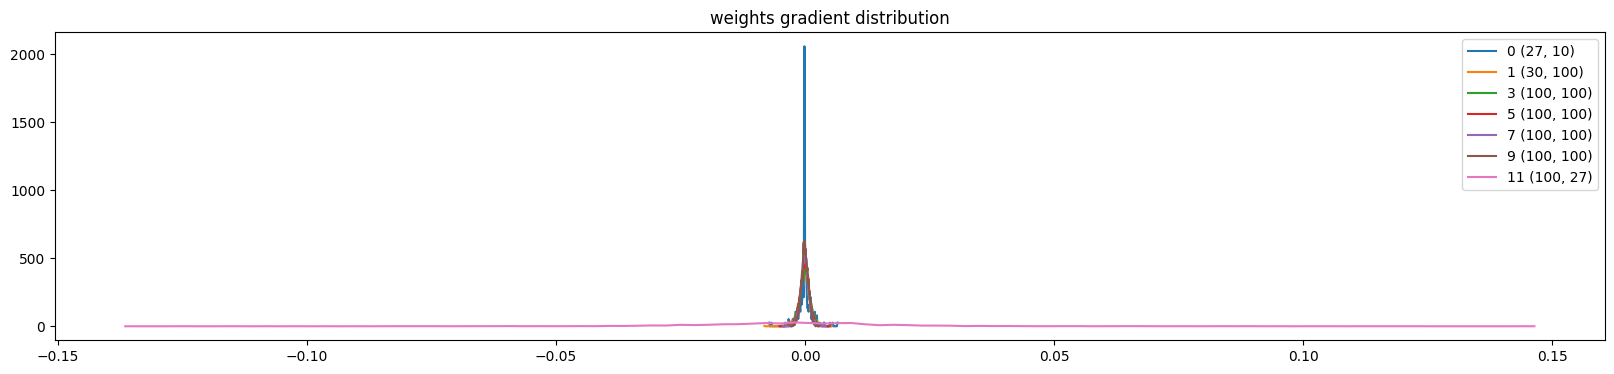

In [193]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

# The grad:data ratio is important. This is because the data is updated by the grad * the learning rate. If the gradient is too large, it'll swing around the data too much
# The issue here is that the gradients for all the layers are about 1 * 10^-3. But the last layer is closer to 1 * 10^-2. So the last layer is training 10 times faster than the other layers!
# This is bad in relation to the data as well - the grad:data ratio for the last layer is just 2! So the gradient is actually larger than the data value itself!
# You can fix this by just inspecting after 1000 iterations or so - it fixes itself a bit.
# However, initialization does matter - as we are wasting cycles, which especially get important in large NNS!

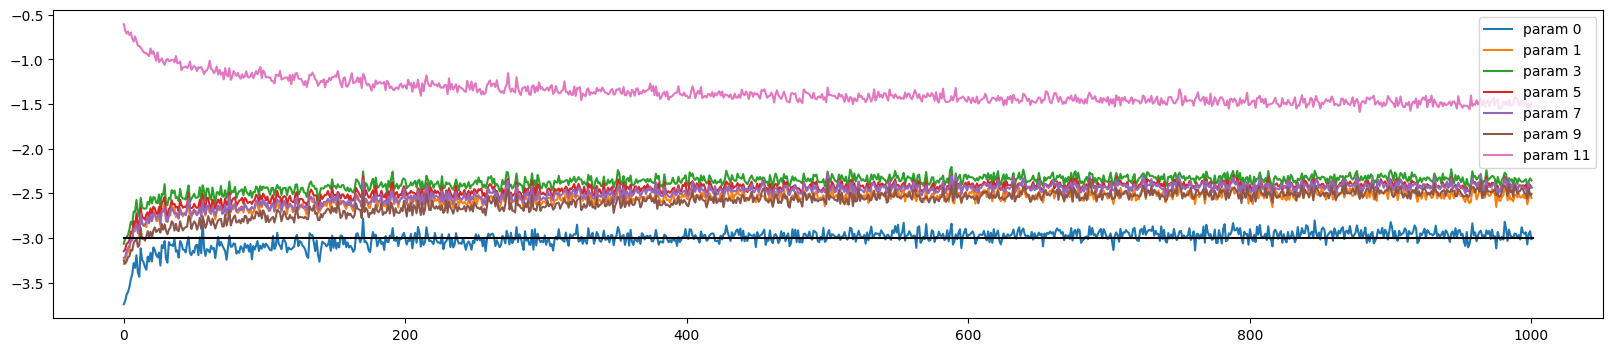

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

# While gradient to data is valuable for insight, what's more valuable is actually the update to gradient value
# Here we notice that after 1000 cycles, the last layer gets closer to ~1e-3. ~1e-3 is a good guideline for the ideal ratio for learning - don't want it to be too much above it.
# If we shrink the lr to .00001, or something, the ratio will get too small! So learning will not happen fast enough
# The reason this happens also is because we artifically shrink the last layer to normalize it to 0.1! So the data gets very small and the gradient dwarfs it

In [217]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  # BatcnNorm1d is typically placed before non-linearity
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), 
  # Can also be placed after the last layer!
  BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [218]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

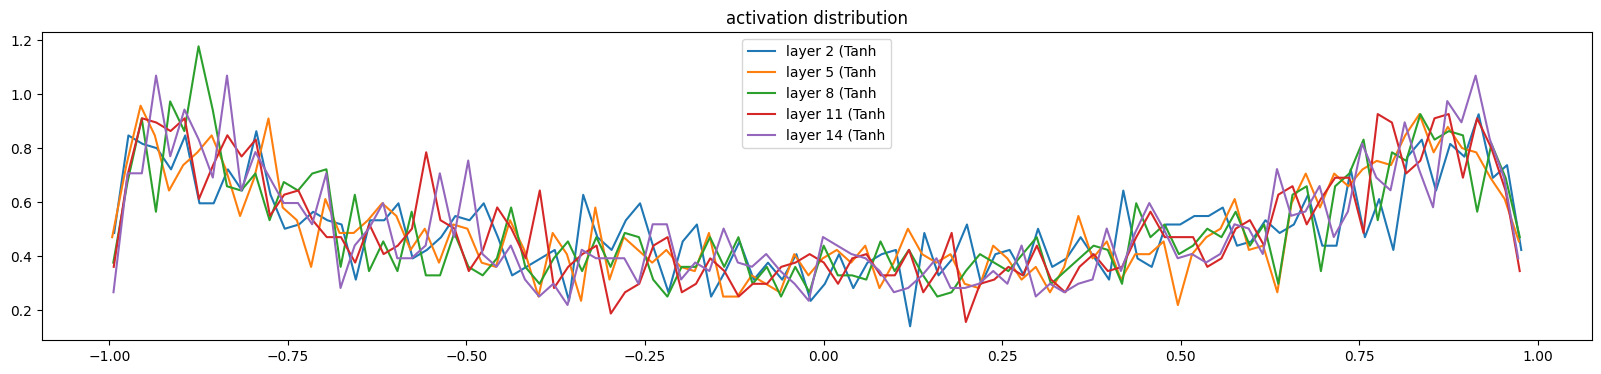

In [219]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682954e-03
layer 5 (      Tanh): mean -0.000000, std 3.262608e-03
layer 8 (      Tanh): mean -0.000000, std 2.973729e-03
layer 11 (      Tanh): mean +0.000000, std 2.741110e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

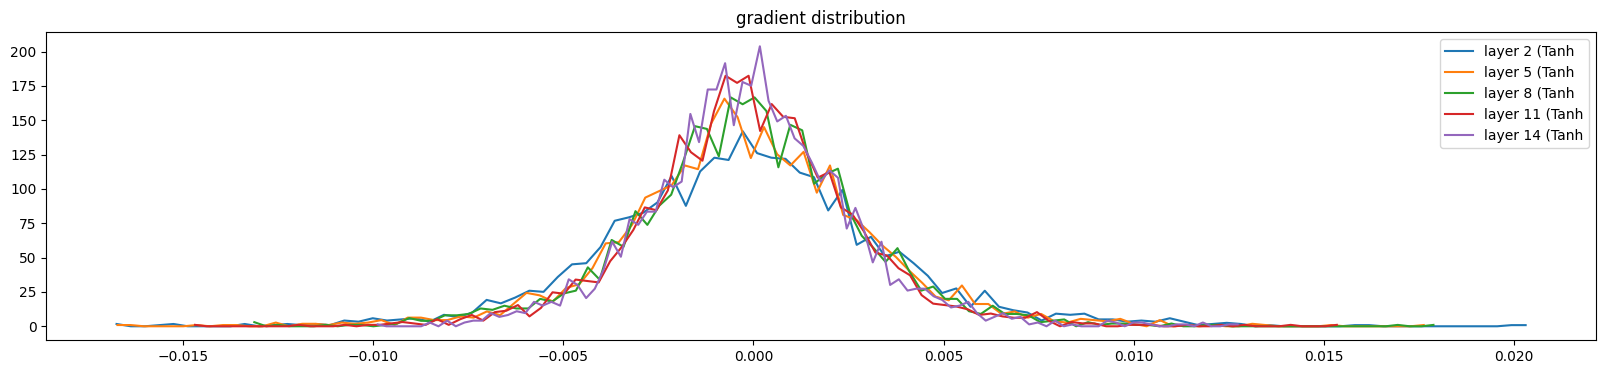

In [220]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.019886e-02 | grad:data ratio 1.018846e-02
weight  (30, 100) | mean +0.000092 | std 8.238428e-03 | grad:data ratio 2.635838e-02
weight (100, 100) | mean +0.000031 | std 7.318113e-03 | grad:data ratio 4.377145e-02
weight (100, 100) | mean -0.000019 | std 6.662025e-03 | grad:data ratio 3.949897e-02
weight (100, 100) | mean -0.000019 | std 5.821515e-03 | grad:data ratio 3.468161e-02
weight (100, 100) | mean +0.000053 | std 5.445295e-03 | grad:data ratio 3.243367e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio 6.281264e-02


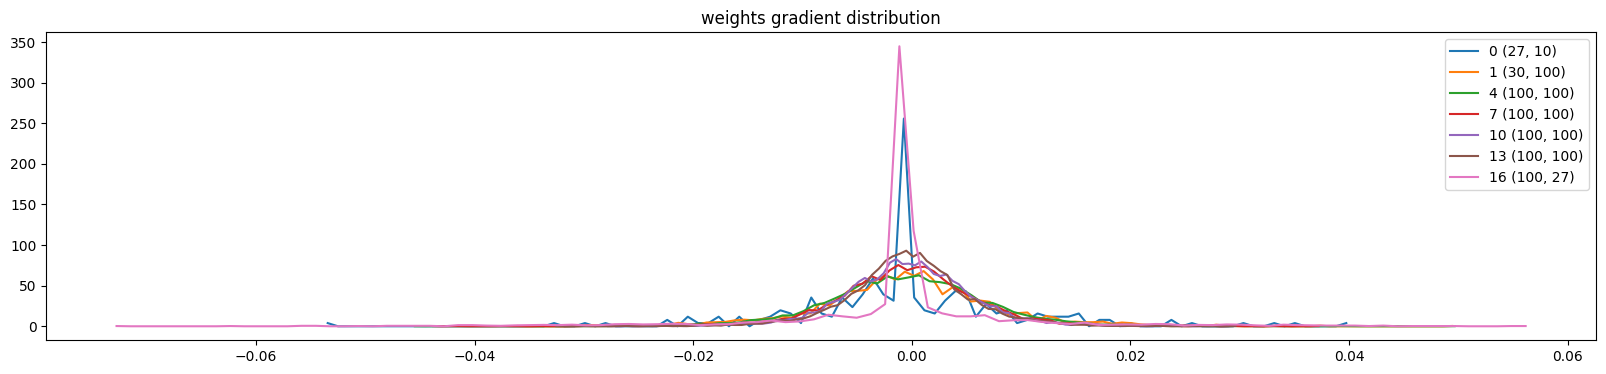

In [221]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

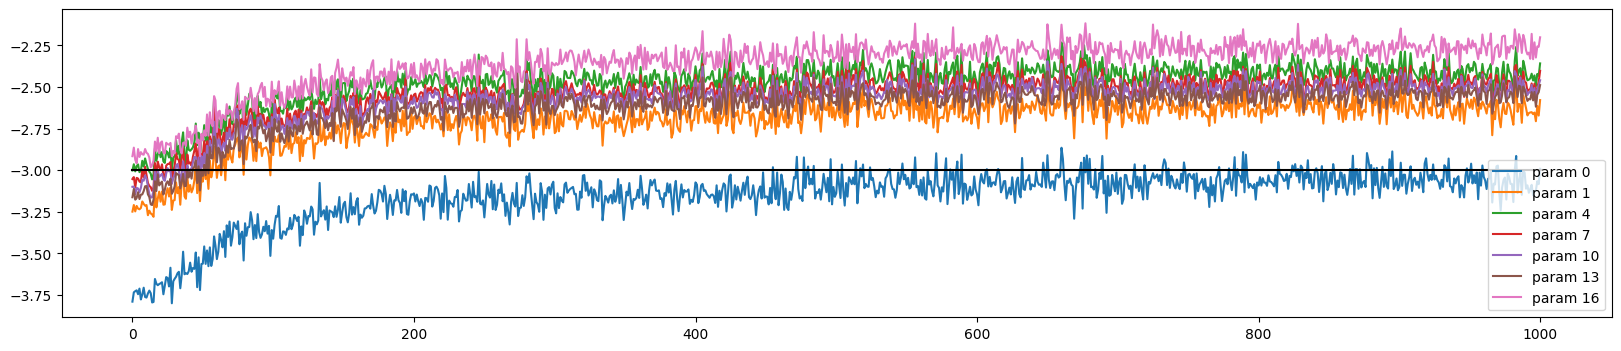

In [222]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [223]:
# With batch norm - it's much easier to adjust weights! If you chagne the scale to let's say, .2 instead of 5/3 - all the graphs are effectively the same, except for the last one!
# So you don't get a full free pass to putting in any values you would like.
# (i.e, if the gain is greator, the values are greater, and the updates are smaller overall as a result)

# With batchnorm, you also don't necessarily need to scale by fan_in if you want as well - since batchnorm takes care of the scaling
# For example, if we get rid of it here - everything is fine except the last graph - which is skewed to 4.
# We can fix this by making the lr 1 instead of .1